# Deep Learning Assignment 7
**Leow Wen Bin / 廖文宾 / (2022280384)**

## Setup

In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torchvision import transforms
from torchvision.datasets import MNIST
from pdb import set_trace as st
from copy import deepcopy

EPS = 1e-10
DATA_DIR = './data'
BATCH_SIZE = 64
Z_SIZE = 40
LR = 0.001
N_EPOCHS = 11
REG_TERM = 0.0001

device = 'cuda'

## Dataset

In [2]:
class BinarizeAndFlatten(object):
    def __init__(self):
        pass
    
    def __call__(self, inp):
        return torch.flatten(inp[0].round())

transform = transforms.Compose([
    transforms.ToTensor(),
    BinarizeAndFlatten()
])

In [3]:
train_set = MNIST(DATA_DIR, train=True, download=True, transform=transform)
test_set = MNIST(DATA_DIR, train=False, download=True, transform=transform)
train_set_size = int(len(train_set) * 0.9)
train_set, val_set = random_split(train_set, (train_set_size, len(train_set) - train_set_size)) 

list(map(len, [train_set, val_set, test_set]))

[54000, 6000, 10000]

In [4]:
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
train_set[0][0].shape

torch.Size([784])

## Model

In [6]:
class Q(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        self.l1 = nn.Linear(784 + 10, 256)
        self.a1 = nn.ReLU()
        self.s = nn.Linear(256, z_size)
        self.m = nn.Linear(256, z_size)
        self.sa = nn.Sigmoid()
        self.ma = nn.Sigmoid()
        
    def forward(self, x, y):
        y = nn.functional.one_hot(y, num_classes=10)
        x = torch.cat([x,y], dim=1)
        x = self.l1(x)
        x = self.a1(x)
        s = self.s(x)
        s = self.sa(s)
        m = self.m(x)
        m = self.ma(m)
        
        return m, s

class P(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        self.l1 = nn.Linear(z_size + 10, 256)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(256, 784)
        self.a2 = nn.Sigmoid()
        
    def forward(self, z, y):
        y = nn.functional.one_hot(y, num_classes=10)
        z = torch.cat([z,y], dim=1)
        z = self.l1(z)
        z = self.a1(z)
        z = self.l2(z)
        z = self.a2(z)
        return z
    
class QP(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        self.P = P(z_size)
        self.Q = Q(z_size)
    
    def forward(self, x, y):
        m, s = self.Q(x, y)
        z = torch.normal(torch.zeros(m.shape), torch.ones(m.shape)).to(device)
        z = z * s
        z = z + m
        x_ = self.P(z, y)
        return x_, m, s

In [7]:
def d_kl(m1, s1, m2, s2):
    kld = torch.sum(torch.log(s2 / (s1+EPS)) + (s1.pow(2) + (m1 - m2).pow(2)) / (2 * s2.pow(2) + EPS) - 0.5)
    return kld
    
def calc_loss(x_, x, m, s, criterion):
    return criterion(x_, x) + REG_TERM * d_kl(m, s, torch.zeros(m.shape).to(device), torch.ones(s.shape).to(device))

## Training

In [8]:
model = QP(Z_SIZE).to(device)
criterion = nn.BCELoss()
opt = Adam(model.parameters(), lr=LR)

In [9]:
epoch_train_losses = []
epoch_val_losses = []
saved_model_weights = []

for epoch in range(N_EPOCHS):
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    model.train()
    for x, y in train_dl:
        opt.zero_grad()
        
        y = y.to(device)
        x = x.to(device)
        x_, m, s = model(x, y)
        loss = calc_loss(x_, x, m, s, criterion)
        
        loss.backward()
        opt.step()
        epoch_train_loss += float(loss.item())
        
    model.eval()
    for x, y in val_dl:
        with torch.no_grad():
            y = y.to(device)
            x = x.to(device)
            x_, m, s = model(x, y)
            loss = calc_loss(x_, x, m, s, criterion)
            epoch_val_loss += float(loss.item())
    
    epoch_train_loss /= len(train_dl)
    epoch_val_loss /= len(val_dl)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    
    print(f'epoch {epoch} trainloss {epoch_train_loss} valloss {epoch_val_loss}')
    if epoch % 5 == 0:
        print('model saved')
        saved_model_weights.append(deepcopy(model.cpu().state_dict()))
        model = model.to(device)

epoch 0 trainloss 0.2469265666367179 valloss 0.21797093781091834
model saved
epoch 1 trainloss 0.21712099302069574 valloss 0.2125166545632065
epoch 2 trainloss 0.21249380246388105 valloss 0.20852357597761256
epoch 3 trainloss 0.20945241637218606 valloss 0.20661406058778045
epoch 4 trainloss 0.2076673464206614 valloss 0.20514757258276786
epoch 5 trainloss 0.20663336591081405 valloss 0.2039782319979001
model saved
epoch 6 trainloss 0.2057511603033274 valloss 0.2033012600675706
epoch 7 trainloss 0.2050227860645043 valloss 0.20322476583783344
epoch 8 trainloss 0.20450232753337916 valloss 0.20263231954266947
epoch 9 trainloss 0.20413080605535744 valloss 0.2020681910617377
epoch 10 trainloss 0.20356905078548554 valloss 0.20160109685954228
model saved


C:\Users\thisi\AppData\Local\Temp\ipykernel_11792\3975824757.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10, 10, y*10 + i + 1)


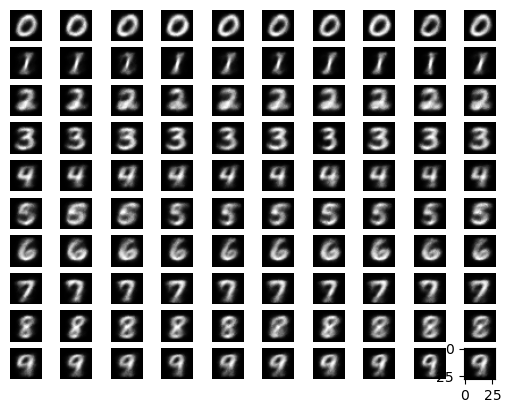

In [10]:
model.eval()
model.load_state_dict(saved_model_weights[0])
model = model.to(device)

for y in range(10):
    for i in range(10):
        x_ = model.P(
            #(-2 + 0.4*i*torch.ones([1,Z_SIZE])).to(device),
            torch.normal(torch.zeros(Z_SIZE), torch.ones(Z_SIZE)).reshape([1,Z_SIZE]).to(device),
            torch.Tensor([y]).long().to(device))
        x_ = x_.reshape([28,28]).detach().cpu().numpy()
        plt.axis('off')
        plt.subplot(10, 10, y*10 + i + 1)
        plt.imshow(x_, cmap='gray')
        
plt.show()

C:\Users\thisi\AppData\Local\Temp\ipykernel_11792\500181588.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10, 10, y*10 + i + 1)


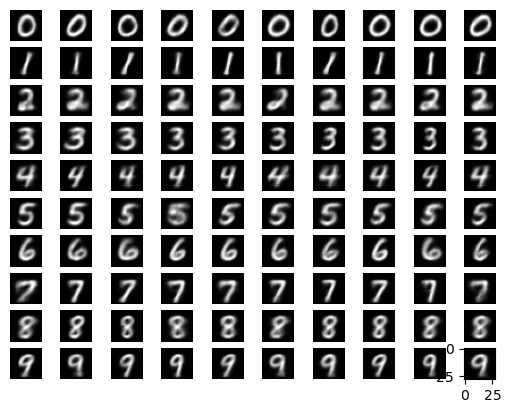

In [11]:
model.eval()
model.load_state_dict(saved_model_weights[1])
model = model.to(device)

for y in range(10):
    for i in range(10):
        x_ = model.P(
            #(-2 + 0.4*i*torch.ones([1,Z_SIZE])).to(device),
            torch.normal(torch.zeros(Z_SIZE), torch.ones(Z_SIZE)).reshape([1,Z_SIZE]).to(device),
            torch.Tensor([y]).long().to(device))
        x_ = x_.reshape([28,28]).detach().cpu().numpy()
        plt.axis('off')
        plt.subplot(10, 10, y*10 + i + 1)
        plt.imshow(x_, cmap='gray')
        
plt.show()

C:\Users\thisi\AppData\Local\Temp\ipykernel_11792\396905263.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10, 10, y*10 + i + 1)


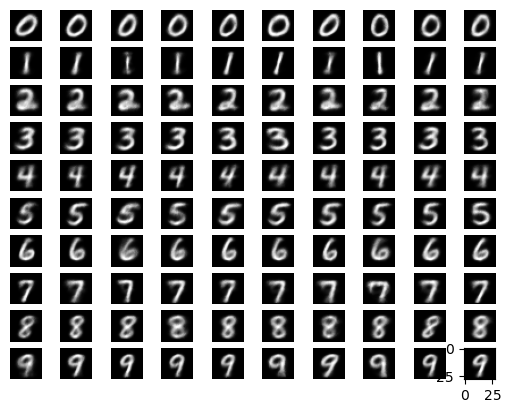

In [12]:
model.eval()
model.load_state_dict(saved_model_weights[2])
model = model.to(device)

for y in range(10):
    for i in range(10):
        x_ = model.P(
            #(-2 + 0.4*i*torch.ones([1,Z_SIZE])).to(device),
            torch.normal(torch.zeros(Z_SIZE), torch.ones(Z_SIZE)).reshape([1,Z_SIZE]).to(device),
            torch.Tensor([y]).long().to(device))
        x_ = x_.reshape([28,28]).detach().cpu().numpy()
        plt.axis('off')
        plt.subplot(10, 10, y*10 + i + 1)
        plt.imshow(x_, cmap='gray')
        
plt.show()

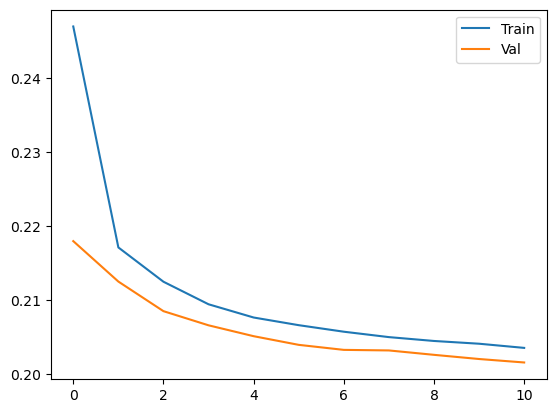

In [13]:
plt.plot(epoch_train_losses)
plt.plot(epoch_val_losses)
plt.legend(['Train', 'Val'])
plt.show()